<img src="pics/arxiv_vs_snarxiv_logo.png" width=300>

# Can snarXiv-vs-arXiv be learned?

**Background**  
The [snarXiv-vs-arXiv](http://snarxiv.org/vs-arxiv/) website challenges you to tell fake physics research articles from real ones. Real paper titles are taken from [arXiv](https://arxiv.org/), fake titles are produced by a so-called context-free grammar. The snarXiv code is freely available ([link](https://github.com/davidsd/snarxiv)). 

**Aim**  
Develop a supervised learning algorithm to correctly classify arXiv vs. snarXiv titles.

**Method**  
- use requests (or selenium webdriver) to scrape a number of titles from the website and parse the correct labels; save this dataset for training/testing
- natural-language processing (NLP): transform the paper titles into a bag-of-words (BOW) model using the scikit-learn CountVectorizer
- train and optimize a classifier (scikit-learn)
- testing: apply the learned classifier to the snarXiv website

**Results**  
- classifiers reach around 90% accuracy on test data sets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import requests # 2.27.1
from tqdm import tqdm
#from selenium import webdriver # not used in the kaggle version of this notebook
import xml.etree.ElementTree as ET

## Download a training data set (*optional*)

This step is optional, the repo already contains a training data set. The function below scrapes `2*n_total` titles from http://snarxiv.org/vs-arxiv/ which are correctly labelled as arXiv (real) or snarXiv (fake).  
The results are stored in a Python dictionary (and optionally written to a file). 

In [ ]:
def download(n_total=10, verbose=False):
    """
    Download 2n samples from: http://snarxiv.org/vs-arxiv"
    The website http://snarxiv.org/vs-arxiv/ generates pairs of 
    arXiv/snarXiv titles by calling the server-side Python script
    http://snarxiv.org/py/fight.py which returns XML data.
    The XML data contains tags 'arxiv' and 'snarxiv', each of 
    which has a 'title' tag, corresponding to arXiv (real) and 
    snarXiv (fake) paper titles.
    """
    url = "http://snarxiv.org/py/fight.py"
    real_titles = []
    fake_titles = []
    for i in tqdm(range(n_total)):
        txt = requests.get(url).content
        root = ET.fromstring(txt)
        real_titles.append(root.find('arxiv').find('title').text)
        fake_titles.append(root.find('snarxiv').find('title').text)

    # review results
    if verbose:
        print("\n[+] Real titles")
        for i, title in enumerate(real_titles):
            print(f"\n#{i:d}\n{title:s}")

        print("\n[+] Fake titles")
        for i, title in enumerate(fake_titles):
            print(f"\n#{i:d}\n{title:s}")

    # save
    f_out = f"./data/training_data.pkl"
    d = {'real' : real_titles, 'fake' : fake_titles}
    with open(f_out, "wb") as fp:
        pickle.dump(d, fp, pickle.HIGHEST_PROTOCOL)
    return real_titles, fake_titles

real, fake = download(n_total=100, verbose=False)
print("Training data downloaded.")

## Load standard training data set
If you haven't downloaded your own training data set, you can work with the standard training data set.

In [3]:
def load_training_data(filename):
    """
    re-load and analyze samples
    """
    with open(filename, "rb") as fp:
        d = pickle.load(fp, encoding='latin1')
    real = d['real']
    fake = d['fake']
    print(f"Loaded n={len(real):d} real and n={len(fake):d} fake samples.")
    return real, fake

f_data = f"data/training_data_std.pkl"  # 1000 titles each
real, fake = load_training_data(f_data)

Loaded n=1000 real and n=1000 fake samples.


## Examples
To better understand the problem, let's have a look at a few titles. Most people have difficulties deciding which titles stem from real papers and which were produced by the context-free grammar. 

In [4]:
print("Some real (arXiv) examples: \n" + 30*"=")
for i, r in enumerate(real[:10]): print(f"#{i:d}: {r.strip():s}", end="\n")
print("\nSome fake (snarXiv) examples: \n" + 30*"=")
for i, f in enumerate(fake[:10]): print(f"#{i:d}: {f.strip():s}", end="\n")

Some real (arXiv) examples: 
#0: Exact Effective Action for (1+1 Dimensional) Fermions in an Abelian Background at Finite Temperature
#1: Four Quark Cn - Nbar Cbar States in U(12)-Scheme and X(3872)/Y(3940)
#2: A Heavy Higgs and a Light Sneutrino NLSP in the MSSM With Enhanced SU(2) D-terms
#3: Exact Analytic Two-loop Expressions for Some QCD Observables in the Time-like Region
#4: Lattice Ising Model in a Field: E$_8$ Scattering Theory
#5: Index Theory, Gerbes, and Hamiltonian Quantization
#6: Consistent Decoupling of Heavy Scalars and Moduli in N=1 Supergravity
#7: A Ten-Dimensional Super-Yang-Mills Action With Off-Shell Supersymmetry
#8: Deformed Poincare Algebra and Field Theory
#9: NNLO QCD Corrections to the B -> X_s Gamma Matrix Elements Using Interpolation in M_c

Some fake (snarXiv) examples: 
#0: On Invertible QED_3
#1: Anomaly Matching in Deformed QFTs
#2: The Multi-field Solution to the LHC Inverse Problem From Inflaton Models (Including the Lithium Problem)
#3: The Hologra

## Text pre-processing
NLP algorithms usually pre-process text data. Common pre-processing steps involve:
- removal of punctuation (e.g.: ,.;!?)
- stemming (e.g. [NLTK package](https://www.nltk.org/howto/stem.html))

Here, we will just apply a very basic pre-processing:
1. Strip trailing "\n" characters
2. Replace "blank-dash-blank" by "dash", e.g. "Quark Cn - Nbar Cbar States" => "Quark Cn-Nbar Cbar States"
3. Replace "blank-arrow-blank" by "arrow", e.g. "the B -> X_s Gamma Matrix" => "the B->X_s Gamma Matrix"
4. Convert all expressions to lowercase

Points 2. and 3. are necessary to avoid splitting expressions such as "Cn - Nbar" into ["Cn", "-", "Nbar"] when titles will be processed by the vectorizer. 

In [5]:
preprocess = lambda s: s.strip().replace(" - ", "-").replace(" -> ", "->").lower()

In [6]:
def preprocess2(s):
    """
    A (slightly) more advanced pre-processor, excluding some simple words
    """
    t = s.strip().replace(" - ", "-").replace(" -> ", "->").lower()
    exclude_list = [' and ',' are ',' for ',' in ',' of ',' on ','on ',' over ',' the ',' vs ']
    for w in exclude_list:
        t = t.replace(w, '')
    return t

## Collate all titles and target labels

In [7]:
def get_titles_labels(real, fake):
    """
    Return a list of all titles (real and fake) and a list of the corresponding target labels (1: real, 0: fake)
    """
    all_titles = [preprocess(title) for title in real+fake]
    y = np.concatenate( (np.ones(len(real)), np.zeros(len(fake))) ) # target values (real: 1, fake: 0)
    return all_titles, y

titles, y = get_titles_labels(real, fake)

## Train-test split
Do an 80-20 split on the data, retaining 20% for final performance evaluation.

In [8]:
from sklearn.model_selection import train_test_split #, StratifiedShuffleSplit
titles_train, titles_test, y_train, y_test = train_test_split(titles, y, test_size=0.2, random_state=1)

## Vectorizer transform
Next, the text data will be transformed to numbers, in order to work with numerical methods such as logistic regression, among others.  

**Options**:
- CountVectorizer
- TfidfVectorizer

**Note:** The vectorizer is trained on the *complete* data set. If the vectorizer is built on the training data set alone, some words in the testing data set may not be recognized.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(max_features=2000)
#vectorizer = TfidfVectorizer(max_features=2000)
vectorizer.fit(titles) # titles_train
voc = vectorizer.vocabulary_
print("Vocabulary size: ", len(voc), " words.")

Vocabulary size:  2000  words.


### Apply vectorizer to train and test data

In [11]:
X_train = vectorizer.transform(titles_train)
X_test = vectorizer.transform(titles_test)
print("Training and test data vectorized.", X_train.shape, X_test.shape)

Training and test data vectorized. (1600, 2000) (400, 2000)


**Side note:** What does the vectorizer do?

In [102]:
# count vectorizer explanation

# example sentences
X = ["this book is not my book", "this book is my book", "this is not a book"]
vec2 = CountVectorizer().fit(X)
voc2 = vec2.vocabulary_
print("\nVocabulary dict: ", voc2)
Y = vec2.transform(X).toarray()
print("\nSentences transformed to array:\n", Y)

print("\nExplanation: ")
voc2_inv = {v: k for k, v in voc2.items()} # inverse vocabulary
for i, x in enumerate(X):
    y = Y[i,:]
    print(f"\nSentence {i:d}: '{x:s}' has been encoded as: ", y)
    print(f"because it has:")
    for j, yj in enumerate(y):
        print(f"{yj:d} instance(s) of '{voc2_inv[j]:s}' and voc2['{voc2_inv[j]:s}'] is {voc2[voc2_inv[j]]:d}")
del X, Y


Vocabulary dict:  {'this': 4, 'book': 0, 'is': 1, 'not': 3, 'my': 2}

Sentences transformed to array:
 [[2 1 1 1 1]
 [2 1 1 0 1]
 [1 1 0 1 1]]

Explanation: 

Sentence 0: 'this book is not my book' has been encoded as:  [2 1 1 1 1]
because it has:
2 instances of 'book' and voc2['book'] is 0
1 instances of 'is' and voc2['is'] is 1
1 instances of 'my' and voc2['my'] is 2
1 instances of 'not' and voc2['not'] is 3
1 instances of 'this' and voc2['this'] is 4

Sentence 1: 'this book is my book' has been encoded as:  [2 1 1 0 1]
because it has:
2 instances of 'book' and voc2['book'] is 0
1 instances of 'is' and voc2['is'] is 1
1 instances of 'my' and voc2['my'] is 2
0 instances of 'not' and voc2['not'] is 3
1 instances of 'this' and voc2['this'] is 4

Sentence 2: 'this is not a book' has been encoded as:  [1 1 0 1 1]
because it has:
1 instances of 'book' and voc2['book'] is 0
1 instances of 'is' and voc2['is'] is 1
0 instances of 'my' and voc2['my'] is 2
1 instances of 'not' and voc2['not'] 

## First ML approach: logistic regression

Data and target labels are prepared, time to train a classifier.

In [35]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"{clf.__class__.__name__:s} accuracy: {score:.1%}")

save_vectorizer = False
if save_vectorizer:
    f_vect = "data/sklearn_snarxiv_vectorizer.pkl"
    with open(f_vect, 'wb') as fp:
        pickle.dump(vectorizer, fp)

save_classifier = False
if save_classifier:
    f_model = "data/sklearn_snarxiv_model.pkl"
    with open(f_model, 'wb') as fp:
        pickle.dump(clf, fp)

LogisticRegression accuracy: 90.0%


## Cross-validation
To test the robustness of this results, do a few runs of cross-validation.

In [36]:
from sklearn.model_selection import cross_val_score
n_cv = 5
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Scores: ", scores)
print(f"Mean score: {np.mean(scores):.2f}")

Scores:  [0.8625 0.8375 0.8375 0.8625 0.8125]
Mean score: 0.84


## Neural network classifier
Let's train a multi-layer perceptron (MLP) classifier.

MLPClassifier accuracy: 92.0%


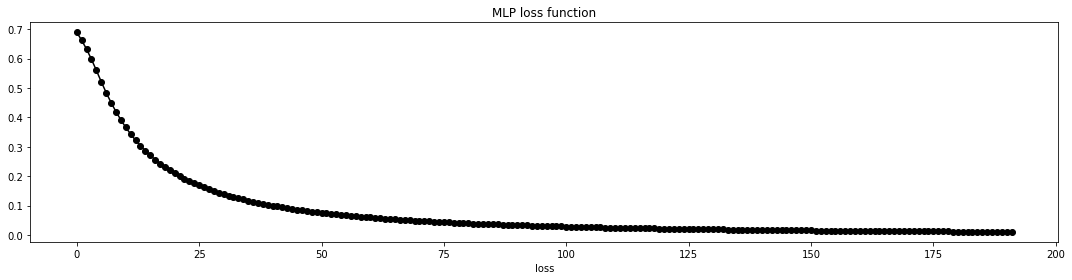

In [37]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(10,), alpha=1e-4, max_iter=300, random_state=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"{clf.__class__.__name__:s} accuracy: {score:.1%}")

plt.figure(figsize=(15,4))
plt.plot(clf.loss_curve_, '-ok')
plt.xlabel("iterations")
plt.xlabel("loss")
plt.title("MLP loss function")
plt.tight_layout()
plt.show()

## Grid search optimization of MLP hyperparameters

Do a gridsearch to find the optimum hyperparameter values for the MLP model and save the results.  
This code block can take a while to complete. If you don't want to wait, skip the next code cell and reload pre-computed results in the next cell after that.

In [ ]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(
    MLPClassifier(random_state=1, max_iter=300),
    param_grid={
        "hidden_layer_sizes": [10, 50, 100],
        "alpha": [0.0001, 0.001, 0.01],
    },
    return_train_score=True,
)
gs.fit(X_train, y_train)
#print(gs.cv_results_)
f_gs = "data/MLP_gridsearch_results.pkl"
with open(f_gs, 'wb') as fp: pickle.dump(gs.cv_results_, fp)

Use pre-computed gridsearch results:

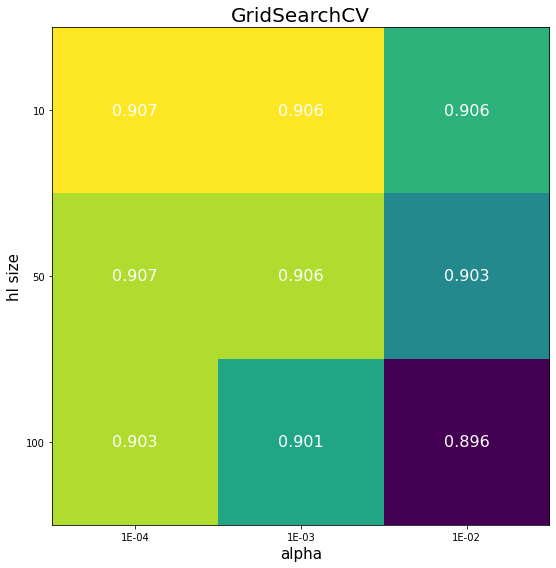

In [42]:
f_gs = "data/MLP_gridsearch_results.pkl"
with open(f_gs, "rb") as fp: mlp_gs = pickle.load(fp, encoding='latin1')
results = pd.DataFrame.from_dict(mlp_gs)
#print(results.head())
scores_matrix = results.pivot(
    index="param_hidden_layer_sizes", columns="param_alpha", values="mean_test_score"
)
#print(scores_matrix)

hl_sizes = [10, 50, 100]
alphas = [0.0001, 0.001, 0.01]

# heatmap adapted from: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
ax.imshow(scores_matrix)
ax.set_xticks(np.arange(len(alphas)))
ax.set_xticklabels(["{:.0E}".format(x) for x in alphas])
ax.set_xlabel("alpha", fontsize=15)
ax.set_yticks(np.arange(len(hl_sizes)))
ax.set_yticklabels(["{:.0f}".format(x) for x in hl_sizes])
ax.set_ylabel("hl size", fontsize=15)
for i in range(len(alphas)):
    for j in range(len(hl_sizes)):
        t = f"{scores_matrix.loc[hl_sizes[j],alphas[i]]:.3f}"
        ax.text(j, i, t, ha="center", va="center", color="w", fontsize=16)
plt.title("GridSearchCV", fontsize=20)
plt.tight_layout()
plt.show()

## Random Forest classifier

Training a Random Forest classifier allows us to inspect the feature importance of individual words.

TODO: optimize hyperparameters

In [39]:
# setup and train the classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100) # 88.8%

rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
print(f"{rf.__class__.__name__:s} accuracy: {score:.1%}")

#from sklearn.ensemble import GradientBoostingClassifier
#gb = GradientBoostingClassifier()

RandomForestClassifier accuracy: 87.8%


Plot feature importances

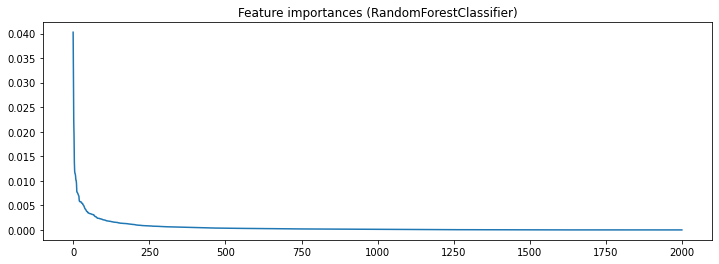

In [40]:
idx_sorted = np.argsort(rf.feature_importances_)[::-1] # descending: max (important) .... min (not important)
vals_sorted = rf.feature_importances_[idx_sorted]
plt.figure(figsize=(12,4))
plt.plot(vals_sorted)
plt.title(f"Feature importances ({rf.__class__.__name__:s})")
plt.show()

Print some features (words), ranked by descending feature importance (most important first).

In [103]:
voc_inv = {v: k for k, v in voc.items()} # inverse vocabulary
df = pd.DataFrame({
    'feature' : [voc_inv[i] for i in range(len(rf.feature_importances_))],
    'importance' : rf.feature_importances_,
}).sort_values(by=['importance'], ascending=False)
df['rank'] = range(len(rf.feature_importances_))
df.index = df['rank']
df.drop('rank', axis=1, inplace=True)
print(df.head(20))
#display(df)

             feature  importance
rank                            
0                and    0.040270
1                 on    0.030029
2            problem    0.022296
3                 of    0.019055
4             models    0.013809
5               type    0.011959
6                 in    0.011507
7              black    0.011397
8                for    0.010923
9             notion    0.010161
10           certain    0.010076
11         instanton    0.009447
12               the    0.007863
13           strings    0.007656
14              some    0.007623
15    correspondence    0.007464
16       orientifold    0.007264
17             field    0.007150
18             gauge    0.007029
19           duality    0.006851


TODO: train without some of: `and, on of, in, for, the`

## Test the classifier online

On our test data set, we got a pretty nice classification accuracy.  
You can apply the trained classifier to the [snarXiv-vs-arXiv](http://snarxiv.org/vs-arxiv/) online using an automated browser like Selenium, but it will be difficult (or impossible?) to display the new browser window through binder or kaggle. The code needed to run the classifier through Selenium is provided below (function `apply_model`) and a screen capture video is shown below that.

In [ ]:
def apply_model(vectorizer=None, clf=None, n_total=1, verbose=False):
    if not vectorizer:
        # re-load vectorizer and model
        f_vect = "sklearn_snarxiv_vectorizer.pkl"
        with open(f_vect, 'rb') as fp:
            vectorizer = pickle.load(fp)

    if not clf:
        f_model = "sklearn_snarxiv_model.pkl"
        with open(f_model, 'rb') as fp:
            clf = pickle.load(fp)

    # connect to snarXiv
    options = webdriver.FirefoxOptions()
    options.add_argument("--headless")
    options.add_argument('--ignore-certificate-errors')
    options.add_argument("--test-type")
    profile = webdriver.FirefoxProfile()
    br = webdriver.Firefox(profile)
    br.get("http://snarxiv.org/vs-arxiv")

    #n_total = 1000 # number of trials
    n = 0 # counter
    n_correct = nc = 0 # current number of correct answers

    # collect titles for future training
    while n <= n_total:
        if verbose: print(f"[+] Trial: {n:d}/{n_total:d}")
        # get DOM elements
        c0 = br.find_element_by_class_name('corner-0')
        h0 = c0.find_element_by_tag_name('h1')
        a0 = h0.find_element_by_tag_name('a')
        txt0 = a0.text.replace("Is this one real?", "") # left title
        c1 = br.find_element_by_class_name('corner-1')
        h1 = c1.find_element_by_tag_name('h1')
        a1 = h1.find_element_by_tag_name('a')
        txt1 = a1.text.replace("Is this one real?", "") # right title
        # use the same preprocessing as during training
        txt0 = preprocess(txt0)
        txt1 = preprocess(txt1)
        # transform title
        x0 = vectorizer.transform([txt0])
        x1 = vectorizer.transform([txt1])
        # get classifier predictions
        pred0 = clf.predict(x0)
        pred1 = clf.predict(x1)
        #print("Predictions: ", pred0, pred1)
        # click the option with the higher classifier score
        if pred0 >= pred1:
            a0.click()
        else:
            a1.click()
        # number of correct guesses
        if n > 0:
            s_nc = br.find_element_by_id('correct').text
            try:
                nc = int(s_nc) # string => int
                if verbose: print(f"\tcorrect (nc = {nc:d})")
            except:
                if verbose: print("error converting nc")
        n += 1
        time.sleep(1)  # wait a sec, just in case...
    print(f"Classifier achieved {100.*nc/n:.1f}% accuracy online.")
    input("finished - quit?")
    br.quit()
    print("browser closed.")

In [ ]:
apply_model(vectorizer, clf, n_total=30, verbose=False)

### Proof of concept
Watch the classifier at work  
<br>
<video src="pics/snarxiv_MLPonline_test_crop.mp4" width=600 controls=true>

### Final note:
There is an easy way to get *all* answers right. The arXiv-vs-snarXiv website sends a GET request to the server-side Python script http://snarxiv.org/py/fight.py which returns XML data. The XML data contains 'arxiv' and 'snarxiv' tags, from which the arXiv and snarXiv titles can be read even before submitting your answer (arrow in the image below). So don't be too impressed by the 100% high scores on http://snarxiv.org/vs-arxiv/highscores/. 

<img src="pics/network_screenshot2.png" width=1000 controls=true>